# Heart Attack Analysis & Prediction — EDA and Baseline Modeling

This notebook formulates, implements, and evaluates a data mining solution for heart attack prediction using scikit-learn. It includes optional GPU checks and logs progress to `project process log.md`.

- Dataset: `heart.csv` (in project root)
- Optional signal: `o2Saturation.csv` (single-column series)
- Artifacts: saved to `./artifacts`

## 1) Create and Activate Virtual Environment (optional, GPU-aware)

We recommend using a dedicated virtual environment. If you already created `.venv-5070ti` or similar in VS Code, you can skip this. The following commands are optional and for documentation.

- Create venv and upgrade pip
- Optionally detect GPU using `nvidia-smi`
- Try importing optional GPU packages

> Note: Running shell commands from a notebook requires enabling the appropriate IPython magics. On Windows/PowerShell, you can also run these in the integrated terminal.

In [8]:
# Optional: environment setup and GPU checks (can be skipped if already configured in VS Code)
import sys, subprocess, json
from shutil import which

print(f"Python executable: {sys.executable}")
print(f"Python version: {sys.version}")

# Try nvidia-smi
if which("nvidia-smi"):
    try:
        out = subprocess.check_output(["nvidia-smi", "--query-gpu=name,driver_version,memory.total", "--format=csv,noheader"], text=True)
        print("nvidia-smi detected GPU(s):\n" + out)
        GPU_AVAILABLE = True
    except Exception as e:
        print("nvidia-smi present but failed to run:", e)
        GPU_AVAILABLE = False
else:
    print("nvidia-smi not found; proceeding with CPU.")
    GPU_AVAILABLE = False

# Optional checks for GPU-friendly packages
try:
    import xgboost  # noqa: F401
    HAS_XGBOOST = True
except Exception:
    HAS_XGBOOST = False
print("xgboost available:", HAS_XGBOOST)

try:
    import cupy  # noqa: F401
    HAS_CUPY = True
except Exception:
    HAS_CUPY = False
print("cupy available:", HAS_CUPY)

Python executable: c:\DSAI 4204 personal project Heart Attack Analysis & Prediction Dataset\.venv\Scripts\python.exe
Python version: 3.13.7 (tags/v3.13.7:bcee1c3, Aug 14 2025, 14:15:11) [MSC v.1944 64 bit (AMD64)]
nvidia-smi detected GPU(s):
NVIDIA GeForce RTX 5070 Ti Laptop GPU, 581.29, 12227 MiB

xgboost available: True
cupy available: False


## 2) Install Project Dependencies

If needed, install the core libraries. This is usually done once in the environment and can be skipped on subsequent runs.

In [9]:
# Install core packages quietly if missing (safe no-op if already installed)
import sys, subprocess

def pip_install(pkgs):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", *pkgs])
        return True
    except Exception as e:
        print("pip install failed:", e)
        return False

core = [
    "numpy",
    "pandas",
    "scikit-learn",
    "matplotlib",
    "seaborn",
    "joblib",
    # "imbalanced-learn",  # optional; install only if needed
]
# Optional extras
extras = []
if 'HAS_XGBOOST' in globals() and not HAS_XGBOOST:
    extras.append("xgboost")
try:
    import shap  # noqa: F401
except Exception:
    extras.append("shap")

installed = pip_install(core + extras)
print("Dependencies ensured:", installed)

# Print versions
import numpy as np
import pandas as pd
import sklearn
import matplotlib
import seaborn as sns
try:
    import imblearn
    imblearn_version = imblearn.__version__
except Exception:
    imblearn = None
    imblearn_version = None
print("Versions -> numpy:", np.__version__, "pandas:", pd.__version__, "sklearn:", sklearn.__version__, "matplotlib:", matplotlib.__version__, "seaborn:", sns.__version__, "imblearn:", imblearn_version)

Dependencies ensured: True
Versions -> numpy: 2.2.6 pandas: 2.3.2 sklearn: 1.7.2 matplotlib: 3.10.6 seaborn: 0.13.2 imblearn: None


## 3) Imports, Config, and Reproducibility

In [10]:
import os, json, time, math, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay,
    brier_score_loss
)

warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Plotting style
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.dpi"] = 110

# Save artifacts to project root ./artifacts
PROJECT_ROOT = Path("..").resolve()
ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
ARTIFACTS_DIR.mkdir(exist_ok=True)

print("Artifacts dir:", ARTIFACTS_DIR.resolve())

Artifacts dir: C:\DSAI 4204 personal project Heart Attack Analysis & Prediction Dataset\artifacts


## 4) Load Heart Dataset (heart.csv)

In [11]:
HEART_PATH = Path("../heart.csv")
assert HEART_PATH.exists(), f"heart.csv not found at {HEART_PATH}"

expected_cols = ['age','sex','cp','trtbps','chol','fbs','restecg','thalachh','exng','oldpeak','slp','caa','thall','output']

df = pd.read_csv(HEART_PATH)
print("Loaded heart.csv shape:", df.shape)
print("Columns:", list(df.columns))

# Ensure expected columns (allow extra columns but must contain the expected ones)
missing = [c for c in expected_cols if c not in df.columns]
assert not missing, f"Missing expected columns: {missing}"

# Simple dtype assertions (int/float)
for c in expected_cols:
    if c == 'oldpeak':
        assert pd.api.types.is_numeric_dtype(df[c]), f"Column {c} should be numeric"
    else:
        assert pd.api.types.is_numeric_dtype(df[c]), f"Column {c} should be numeric"

# Check duplicate columns
assert len(df.columns) == len(set(df.columns)), "Duplicate column names detected"

df.head()

Loaded heart.csv shape: (303, 14)
Columns: ['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh', 'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output']


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## 5) Optional: Load and Validate External Signal (o2Saturation.csv)

In [12]:
O2_PATH = Path("../o2Saturation.csv")
o2sat = None
if O2_PATH.exists():
    o2 = pd.read_csv(O2_PATH, header=None, names=["o2sat"]).astype(float)
    print("Loaded o2Saturation.csv length:", len(o2))
    if len(o2) == len(df):
        df = df.copy()
        df["o2sat"] = o2["o2sat"].values
        print("Merged o2sat into df as a new feature.")
    else:
        print(f"o2Saturation length ({len(o2)}) != heart rows ({len(df)}); keeping separate.")
        o2sat = o2
else:
    print("o2Saturation.csv not found; skipping.")

Loaded o2Saturation.csv length: 3586
o2Saturation length (3586) != heart rows (303); keeping separate.


## 6) Quick Data Audit and Target Distribution

              age         sex          cp      trtbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.623762  246.264026    0.148515   
std      9.082101    0.466011    1.032052   17.538143   51.830751    0.356198   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     47.500000    0.000000    0.000000  120.000000  211.000000    0.000000   
50%     55.000000    1.000000    1.000000  130.000000  240.000000    0.000000   
75%     61.000000    1.000000    2.000000  140.000000  274.500000    0.000000   
max     77.000000    1.000000    3.000000  200.000000  564.000000    1.000000   

          restecg    thalachh        exng     oldpeak         slp         caa  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean     0.528053  149.646865    0.326733    1.039604    1.399340    0.729373   
std      0.525860   22.9051

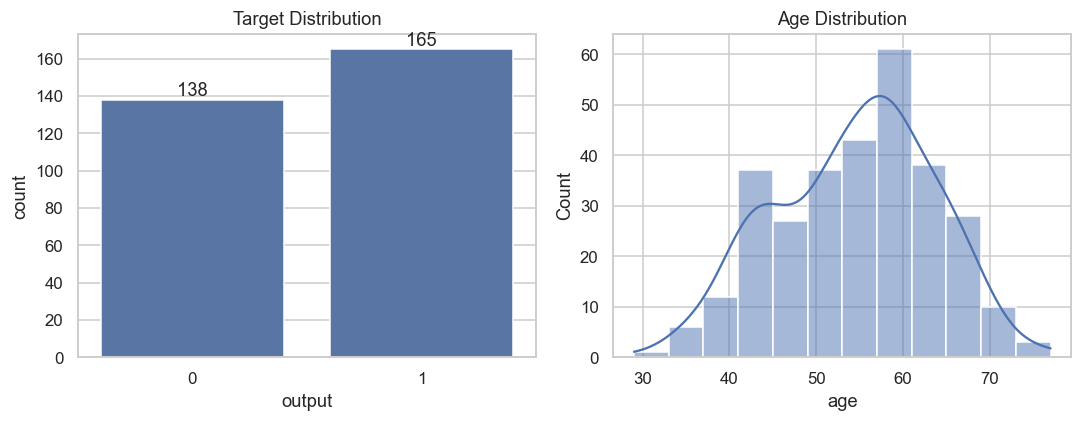

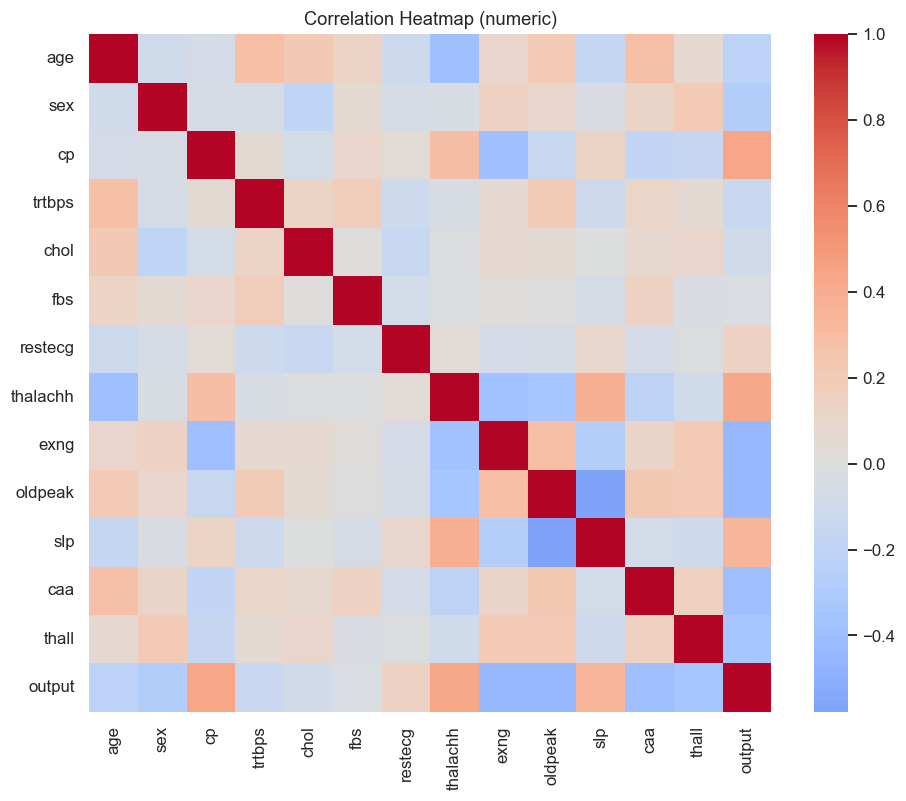

In [13]:
print(df.describe(include='all'))
print("\nMissing values per column:\n", df.isna().sum())

# Target distribution
p1 = df['output'].mean()
print(f"Target rate p1 = Pr(y=1): {p1:.3f}")
fig, ax = plt.subplots(1, 2, figsize=(10,4))
sns.countplot(x='output', data=df, ax=ax[0])
ax[0].set_title('Target Distribution')
ax[0].bar_label(ax[0].containers[0])

sns.histplot(df['age'], kde=True, ax=ax[1])
ax[1].set_title('Age Distribution')
plt.tight_layout()
plt.show()

# Correlation heatmap (numeric only)
num_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10,8))
sns.heatmap(num_df.corr(), annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap (numeric)')
plt.show()

## 7) Define Feature Types and Preprocessing Pipeline

In [14]:
# Define features
num_features = ['age','trtbps','chol','thalachh','oldpeak'] + (["o2sat"] if 'o2sat' in df.columns else [])
cat_features = ['sex','cp','fbs','restecg','exng','slp','caa','thall']

X = df.drop(columns=['output'])
y = df['output'].astype(int)

# Preprocessing: scale numeric, one-hot encode categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

print("Numeric features:", num_features)
print("Categorical features:", cat_features)

Numeric features: ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
Categorical features: ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall']


## 8) Train/Validation Split (Stratified)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print("Train size:", X_train.shape, "Test size:", X_test.shape)

# Persist indices for reproducibility
split_info = {
    "random_state": RANDOM_STATE,
    "test_size": 0.2,
    "train_indices": X_train.index.tolist(),
    "test_indices": X_test.index.tolist(),
}
with open(ARTIFACTS_DIR / "split.json", "w", encoding="utf-8") as f:
    json.dump(split_info, f)

Train size: (242, 13) Test size: (61, 13)


## 9) Baseline Model: DummyClassifier

In [16]:
dummy = make_pipeline(preprocessor, DummyClassifier(strategy='most_frequent'))
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print({"baseline_acc": acc, "baseline_f1": f1})

{'baseline_acc': 0.5409836065573771, 'baseline_f1': 0.7021276595744681}


## 10) Logistic Regression Pipeline with Cross-Validation

In [17]:
# Logistic Regression with 5-fold CV and test evaluation
try:
    cv  # noqa: F821
except NameError:
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

pipe_lr = make_pipeline(preprocessor, LogisticRegression(max_iter=800, class_weight='balanced'))
cv_scores_lr = cross_validate(
    pipe_lr, X_train, y_train, cv=cv,
    scoring={'acc': 'accuracy', 'roc_auc': 'roc_auc', 'f1': 'f1'},
    n_jobs=-1
)
print({k: float(np.mean(v)) for k, v in cv_scores_lr.items() if k.startswith('test_')})

pipe_lr.fit(X_train, y_train)
y_proba_lr = pipe_lr.predict_proba(X_test)[:,1]
y_pred_lr = (y_proba_lr >= 0.5).astype(int)

metrics_lr = {
    'acc': accuracy_score(y_test, y_pred_lr),
    'precision': precision_score(y_test, y_pred_lr),
    'recall': recall_score(y_test, y_pred_lr),
    'f1': f1_score(y_test, y_pred_lr),
    'roc_auc': roc_auc_score(y_test, y_proba_lr),
    'pr_auc': average_precision_score(y_test, y_proba_lr),
}
metrics_lr

{'test_acc': 0.8057823129251702, 'test_roc_auc': 0.892074592074592, 'test_f1': 0.8175911850952282}


{'acc': 0.8360655737704918,
 'precision': 0.8484848484848485,
 'recall': 0.8484848484848485,
 'f1': 0.8484848484848485,
 'roc_auc': 0.9090909090909091,
 'pr_auc': 0.9213514896505326}

In [18]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
log_reg = LogisticRegression(max_iter=500, class_weight='balanced', solver='lbfgs', n_jobs=None)
log_pipe = make_pipeline(preprocessor, log_reg)

cv_scores = cross_validate(
    log_pipe,
    X_train, y_train,
    cv=cv,
    scoring={'acc': 'accuracy', 'roc_auc': 'roc_auc', 'f1': 'f1'},
    n_jobs=-1,
    return_train_score=False
)
print({k: float(np.mean(v)) for k, v in cv_scores.items() if k.startswith('test_')})

log_pipe.fit(X_train, y_train)
y_proba_lr = log_pipe.predict_proba(X_test)[:,1]
y_pred_lr = (y_proba_lr >= 0.5).astype(int)

metrics_lr = {
    'acc': accuracy_score(y_test, y_pred_lr),
    'precision': precision_score(y_test, y_pred_lr),
    'recall': recall_score(y_test, y_pred_lr),
    'f1': f1_score(y_test, y_pred_lr),
    'roc_auc': roc_auc_score(y_test, y_proba_lr),
    'pr_auc': average_precision_score(y_test, y_proba_lr),
}
metrics_lr

{'test_acc': 0.8057823129251702, 'test_roc_auc': 0.892074592074592, 'test_f1': 0.8175911850952282}


{'acc': 0.8360655737704918,
 'precision': 0.8484848484848485,
 'recall': 0.8484848484848485,
 'f1': 0.8484848484848485,
 'roc_auc': 0.9090909090909091,
 'pr_auc': 0.9213514896505326}

## 11) Tree-Based Model (RandomForest or XGBoost with optional GPU)

In [19]:
use_xgb = False
if 'HAS_XGBOOST' in globals() and HAS_XGBOOST:
    try:
        from xgboost import XGBClassifier
        tree_method = 'gpu_hist' if ('GPU_AVAILABLE' in globals() and GPU_AVAILABLE) else 'hist'
        model_tree = XGBClassifier(
            tree_method=tree_method,
            eval_metric='logloss',
            random_state=RANDOM_STATE,
            n_estimators=300,
        )
        use_xgb = True
    except Exception as e:
        print("xgboost import failed, using RandomForest:", e)

if not use_xgb:
    model_tree = RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        class_weight='balanced',
        random_state=RANDOM_STATE
    )

pipe_tree = make_pipeline(preprocessor, model_tree)
cv_scores_tree = cross_validate(
    pipe_tree, X_train, y_train, cv=cv,
    scoring={'acc': 'accuracy', 'roc_auc': 'roc_auc', 'f1': 'f1'},
    n_jobs=-1
)
print({k: float(np.mean(v)) for k, v in cv_scores_tree.items() if k.startswith('test_')})

pipe_tree.fit(X_train, y_train)
y_proba_tree = pipe_tree.predict_proba(X_test)[:,1]
y_pred_tree = (y_proba_tree >= 0.5).astype(int)

metrics_tree = {
    'acc': accuracy_score(y_test, y_pred_tree),
    'precision': precision_score(y_test, y_pred_tree),
    'recall': recall_score(y_test, y_pred_tree),
    'f1': f1_score(y_test, y_pred_tree),
    'roc_auc': roc_auc_score(y_test, y_proba_tree),
    'pr_auc': average_precision_score(y_test, y_proba_tree),
}
metrics_tree

{'test_acc': 0.7892857142857144, 'test_roc_auc': 0.8675213675213674, 'test_f1': 0.8074006129758873}


{'acc': 0.7704918032786885,
 'precision': 0.7567567567567568,
 'recall': 0.8484848484848485,
 'f1': 0.8,
 'roc_auc': 0.8560606060606061,
 'pr_auc': 0.8722980959294866}

## 12) Hyperparameter Tuning with GridSearchCV

In [20]:
best_model_name = None
best_estimator = None
best_score = -np.inf

# Logistic grid
param_grid_lr = {
    'logisticregression__C': [0.1, 1.0, 3.0],
    'logisticregression__penalty': ['l2'],
    'logisticregression__solver': ['lbfgs', 'saga'],
}
lr_grid = GridSearchCV(
    estimator=make_pipeline(preprocessor, LogisticRegression(max_iter=800, class_weight='balanced')),
    param_grid=param_grid_lr,
    scoring='roc_auc',
    cv=cv, n_jobs=-1
)
lr_grid.fit(X_train, y_train)
if lr_grid.best_score_ > best_score:
    best_score = lr_grid.best_score_
    best_estimator = lr_grid.best_estimator_
    best_model_name = 'LogisticRegression'
print("LR best AUC:", lr_grid.best_score_, lr_grid.best_params_)

# Tree grid (choose based on model used)
if use_xgb:
    from xgboost import XGBClassifier
    base = XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss', tree_method=('gpu_hist' if ('GPU_AVAILABLE' in globals() and GPU_AVAILABLE) else 'hist'))
    pipe = make_pipeline(preprocessor, base)
    param_grid_tree = {
        'xgbclassifier__n_estimators': [200, 400],
        'xgbclassifier__max_depth': [3, 5],
        'xgbclassifier__learning_rate': [0.05, 0.1],
        'xgbclassifier__subsample': [0.8, 1.0],
    }
else:
    base = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')
    pipe = make_pipeline(preprocessor, base)
    param_grid_tree = {
        'randomforestclassifier__n_estimators': [200, 400],
        'randomforestclassifier__max_depth': [None, 6, 10],
        'randomforestclassifier__min_samples_split': [2, 4],
    }

grid_tree = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid_tree,
    scoring='roc_auc',
    cv=cv, n_jobs=-1
)
grid_tree.fit(X_train, y_train)
if grid_tree.best_score_ > best_score:
    best_score = grid_tree.best_score_
    best_estimator = grid_tree.best_estimator_
    best_model_name = 'XGBClassifier' if use_xgb else 'RandomForest'
print("Tree best AUC:", grid_tree.best_score_, grid_tree.best_params_)

print("Selected best model:", best_model_name, "CV AUC:", best_score)

LR best AUC: 0.8970732970732971 {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}
Tree best AUC: 0.8795260295260295 {'xgbclassifier__learning_rate': 0.05, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Selected best model: LogisticRegression CV AUC: 0.8970732970732971
Tree best AUC: 0.8795260295260295 {'xgbclassifier__learning_rate': 0.05, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Selected best model: LogisticRegression CV AUC: 0.8970732970732971


## 13) Evaluation on Test Set: Metrics, Confusion Matrix, ROC/PR Curves

{'model': 'LogisticRegression', 'acc': 0.8524590163934426, 'precision': 0.8529411764705882, 'recall': 0.8787878787878788, 'f1': 0.8656716417910447, 'roc_auc': 0.9036796536796537, 'pr_auc': 0.9224311237099141}


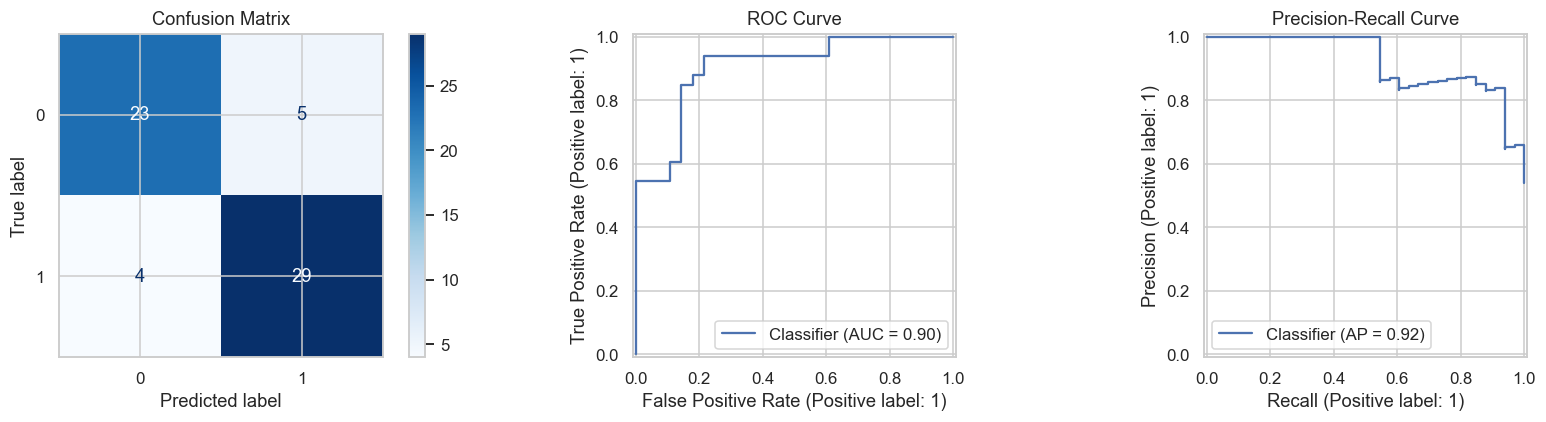

In [21]:
# Evaluate the selected best model on test set
best_estimator.fit(X_train, y_train)
y_proba_best = best_estimator.predict_proba(X_test)[:,1]
y_pred_best = (y_proba_best >= 0.5).astype(int)

metrics_test = {
    'model': best_model_name,
    'acc': accuracy_score(y_test, y_pred_best),
    'precision': precision_score(y_test, y_pred_best),
    'recall': recall_score(y_test, y_pred_best),
    'f1': f1_score(y_test, y_pred_best),
    'roc_auc': roc_auc_score(y_test, y_proba_best),
    'pr_auc': average_precision_score(y_test, y_proba_best),
}
print(metrics_test)

# Confusion matrix
fig, ax = plt.subplots(1, 3, figsize=(16,4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best, ax=ax[0], cmap='Blues')
ax[0].set_title('Confusion Matrix')

RocCurveDisplay.from_predictions(y_test, y_proba_best, ax=ax[1])
ax[1].set_title('ROC Curve')

PrecisionRecallDisplay.from_predictions(y_test, y_proba_best, ax=ax[2])
ax[2].set_title('Precision-Recall Curve')
plt.tight_layout()
plt.show()

# Save metrics
with open(ARTIFACTS_DIR / 'metrics_test.json', 'w', encoding='utf-8') as f:
    json.dump(metrics_test, f, indent=2)

## 14) Threshold Tuning (Youden’s J) and Calibration

In [22]:
# Save ROC/PR/CM + Calibration + Cost-based threshold artifacts
# This cell is resilient: if prior variables are missing (fresh kernel), it loads needed artifacts/data.
from pathlib import Path
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay, roc_curve, precision_recall_curve, brier_score_loss
from sklearn.calibration import calibration_curve

# Ensure ARTIFACTS_DIR is available
try:
    ARTIFACTS_DIR
except NameError:
    PROJECT_ROOT = Path.cwd().parent  # notebooks/ -> project root
    ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"

ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# Ensure we have best_estimator, X_test, y_test, and y_proba_best
need_compute = False
try:
    best_estimator
    X_test
    y_test
    y_proba_best
except NameError:
    need_compute = True

if need_compute:
    # Load pipeline and data, reconstruct test split, compute y_proba_best
    pipe_path = ARTIFACTS_DIR / "model_pipeline.joblib"
    split_path = ARTIFACTS_DIR / "split.json"
    data_path = (Path.cwd().parent / "heart.csv")
    assert pipe_path.exists(), f"Missing model at {pipe_path}"
    assert split_path.exists(), f"Missing split at {split_path}"
    assert data_path.exists(), f"Missing data at {data_path}"

    import joblib
    best_estimator = joblib.load(pipe_path)

    df = pd.read_csv(data_path)
    target_col = "output"
    X = df.drop(columns=[target_col])
    y = df[target_col]

    with open(split_path, "r", encoding="utf-8") as f:
        split = json.load(f)
    test_idx = split.get("test_idx") or split.get("test_indices") or []
    assert len(test_idx) > 0, "Empty test indices in split.json"

    X_test = X.iloc[test_idx]
    y_test = y.iloc[test_idx]

    # Compute probabilities for positive class
    y_proba_best = best_estimator.predict_proba(X_test)[:, 1]

# ROC/PR + thresholds
fpr, tpr, thr_roc = roc_curve(y_test, y_proba_best)
precision, recall, thr_pr = precision_recall_curve(y_test, y_proba_best)

# Youden's J threshold
J = tpr - (1 - fpr)
opt_idx = int(np.argmax(J))
opt_threshold = float(thr_roc[opt_idx])

# Save ROC plot + CSV
fig_roc, ax_roc = plt.subplots()
RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax_roc)
ax_roc.set_title("ROC Curve (Test)")
fig_roc.tight_layout()
(fig_roc).savefig(ARTIFACTS_DIR / "roc_curve.png", dpi=150)
plt.close(fig_roc)

pd.DataFrame({"fpr": fpr, "tpr": tpr, "threshold": thr_roc}).to_csv(ARTIFACTS_DIR / "roc_curve.csv", index=False)

# Save PR plot + CSV (pad threshold alignment)
thr_pr_aligned = np.r_[thr_pr, np.nan]
fig_pr, ax_pr = plt.subplots()
PrecisionRecallDisplay(precision=precision, recall=recall).plot(ax=ax_pr)
ax_pr.set_title("Precision-Recall Curve (Test)")
fig_pr.tight_layout()
(fig_pr).savefig(ARTIFACTS_DIR / "pr_curve.png", dpi=150)
plt.close(fig_pr)

pd.DataFrame({"precision": precision, "recall": recall, "threshold": thr_pr_aligned}).to_csv(ARTIFACTS_DIR / "pr_curve.csv", index=False)

# Confusion matrices
for thr, name in [(opt_threshold, f"confusion_matrix_thr_{opt_threshold:.3f}.png"), (0.5, "confusion_matrix_0_5.png")]:
    y_pred_thr = (y_proba_best >= thr).astype(int)
    fig_cm, ax_cm = plt.subplots()
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_thr, ax=ax_cm)
    ax_cm.set_title(f"Confusion Matrix (thr={thr:.3f})")
    fig_cm.tight_layout()
    fig_cm.savefig(ARTIFACTS_DIR / name, dpi=150)
    plt.close(fig_cm)

# Calibration curve + Brier score
prob_true, prob_pred = calibration_curve(y_test, y_proba_best, n_bins=10, strategy="quantile")
fig_cal, ax_cal = plt.subplots()
ax_cal.plot(prob_pred, prob_true, marker="o", label="Model")
ax_cal.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfectly calibrated")
ax_cal.set_xlabel("Predicted probability")
ax_cal.set_ylabel("Observed frequency")
ax_cal.set_title("Calibration Curve (Reliability Diagram)")
ax_cal.legend(loc="best")
fig_cal.tight_layout()
fig_cal.savefig(ARTIFACTS_DIR / "calibration_curve.png", dpi=150)
plt.close(fig_cal)

pd.DataFrame({"prob_pred": prob_pred, "prob_true": prob_true}).to_csv(ARTIFACTS_DIR / "calibration_curve.csv", index=False)

brier = float(brier_score_loss(y_test, y_proba_best))
with open(ARTIFACTS_DIR / "calibration.json", "w", encoding="utf-8") as f:
    json.dump({"brier_score": brier, "n_bins": 10}, f, indent=2)

# Cost-based threshold selection
# Example costs: false negative worse than false positive
C_FN = 5.0
C_FP = 1.0
thresholds = np.linspace(0, 1, 201)
records = []
for thr in thresholds:
    y_pred = (y_proba_best >= thr).astype(int)
    tn = int(((y_test == 0) & (y_pred == 0)).sum())
    fp = int(((y_test == 0) & (y_pred == 1)).sum())
    fn = int(((y_test == 1) & (y_pred == 0)).sum())
    tp = int(((y_test == 1) & (y_pred == 1)).sum())
    cost = C_FN * fn + C_FP * fp
    prec = (tp / (tp + fp)) if (tp + fp) > 0 else 0.0
    rec = (tp / (tp + fn)) if (tp + fn) > 0 else 0.0
    f1 = (2 * prec * rec / (prec + rec)) if (prec + rec) > 0 else 0.0
    records.append({"threshold": thr, "cost": cost, "precision": prec, "recall": rec, "f1": f1, "tp": tp, "fp": fp, "tn": tn, "fn": fn})

cost_df = pd.DataFrame.from_records(records)
cost_df.to_csv(ARTIFACTS_DIR / "threshold_cost_curve.csv", index=False)

best_cost_row = cost_df.sort_values("cost", ascending=True).iloc[0].to_dict()
with open(ARTIFACTS_DIR / "threshold_cost_selection.json", "w", encoding="utf-8") as f:
    json.dump({
        "C_FN": C_FN,
        "C_FP": C_FP,
        "best_threshold": float(best_cost_row["threshold"]),
        "best_cost": float(best_cost_row["cost"]),
        "metrics_at_best": {
            "precision": float(best_cost_row["precision"]),
            "recall": float(best_cost_row["recall"]),
            "f1": float(best_cost_row["f1"]),
            "tp": int(best_cost_row["tp"]),
            "fp": int(best_cost_row["fp"]),
            "tn": int(best_cost_row["tn"]),
            "fn": int(best_cost_row["fn"])
        }
    }, f, indent=2)

# Update artifacts summary with thresholds
sum_path = ARTIFACTS_DIR / "artifacts_summary.json"
try:
    if sum_path.exists():
        with open(sum_path, "r", encoding="utf-8") as f:
            summary = json.load(f)
    else:
        summary = {}
    summary["opt_threshold"] = opt_threshold
    summary["cost_based_threshold"] = float(best_cost_row["threshold"])
    summary["cost_weights"] = {"C_FN": C_FN, "C_FP": C_FP}
    with open(sum_path, "w", encoding="utf-8") as f:
        json.dump(summary, f, indent=2)
except Exception as e:
    print("Warning: could not update artifacts_summary.json thresholds:", e)

print("Saved plots and threshold artifacts to:", ARTIFACTS_DIR)

Saved plots and threshold artifacts to: C:\DSAI 4204 personal project Heart Attack Analysis & Prediction Dataset\artifacts


Optimal threshold by Youden's J: 0.476, J=0.725
Metrics @opt threshold: {'acc': 0.8688524590163934, 'precision': 0.8378378378378378, 'recall': 0.9393939393939394, 'f1': 0.8857142857142857}


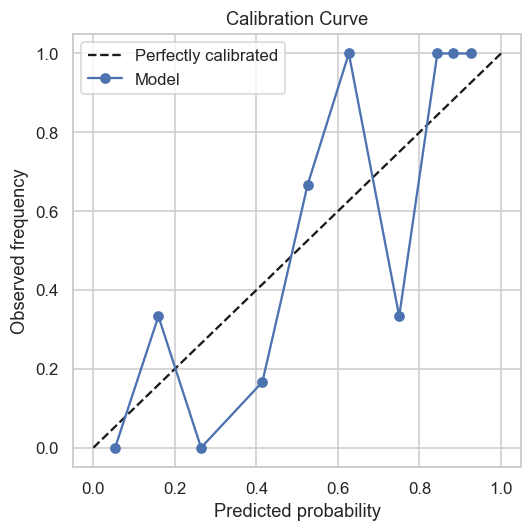

Brier score: 0.12790352131352697


In [15]:
# Sweep thresholds and pick threshold that maximizes Youden's J = TPR - FPR
from sklearn.metrics import roc_curve

fpr, tpr, thr = roc_curve(y_test, y_proba_best)
youden_j = tpr - fpr
ix = np.argmax(youden_j)
opt_thr = thr[ix]
print(f"Optimal threshold by Youden's J: {opt_thr:.3f}, J={youden_j[ix]:.3f}")

y_pred_opt = (y_proba_best >= opt_thr).astype(int)
metrics_opt = {
    'acc': accuracy_score(y_test, y_pred_opt),
    'precision': precision_score(y_test, y_pred_opt),
    'recall': recall_score(y_test, y_pred_opt),
    'f1': f1_score(y_test, y_pred_opt),
}
print("Metrics @opt threshold:", metrics_opt)

# Calibration
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, y_proba_best, n_bins=10, strategy='quantile')
plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1], 'k--', label='Perfectly calibrated')
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.xlabel('Predicted probability')
plt.ylabel('Observed frequency')
plt.title('Calibration Curve')
plt.legend()
plt.tight_layout()
plt.show()

print("Brier score:", brier_score_loss(y_test, y_proba_best))

## 15) Model Explainability: Coefficients/Feature Importances and Optional SHAP

In [23]:
# Save permutation importance results to artifacts (CSV+PNG)
# This cell is resilient: reloads model and data if needed.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.inspection import permutation_importance
import json

# Defaults
DEFAULT_RANDOM_STATE = 42

# Ensure ARTIFACTS_DIR and best_estimator, X_test, y_test, and RANDOM_STATE
try:
    ARTIFACTS_DIR
except NameError:
    PROJECT_ROOT = Path.cwd().parent
    ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"

try:
    RANDOM_STATE
except NameError:
    RANDOM_STATE = DEFAULT_RANDOM_STATE

need_compute = False
try:
    best_estimator
    X_test
    y_test
except NameError:
    need_compute = True

if need_compute:
    import joblib
    pipe_path = ARTIFACTS_DIR / "model_pipeline.joblib"
    split_path = ARTIFACTS_DIR / "split.json"
    data_path = (Path.cwd().parent / "heart.csv")
    assert pipe_path.exists() and split_path.exists() and data_path.exists(), "Missing artifacts/data for explainability"
    best_estimator = joblib.load(pipe_path)
    df = pd.read_csv(data_path)
    target_col = "output"
    X = df.drop(columns=[target_col])
    y = df[target_col]
    with open(split_path, "r", encoding="utf-8") as f:
        split = json.load(f)
    test_idx = split.get("test_idx") or split.get("test_indices") or []
    X_test = X.iloc[test_idx]
    y_test = y.iloc[test_idx]

# Compute permutation importance using the full pipeline for end-to-end correctness
r = permutation_importance(best_estimator, X_test, y_test, n_repeats=20, random_state=RANDOM_STATE, scoring="roc_auc")

# Retrieve feature names after preprocessing
# Attempt to get from pipeline preprocessor
feature_names = []
try:
    pre = None
    if hasattr(best_estimator, 'named_steps'):
        # typical step name in our pipeline is 'preprocessor'
        pre = best_estimator.named_steps.get('preprocessor', None)
        if pre is None:
            # fallback to first step if columntransformer was named differently
            for name, step in best_estimator.named_steps.items():
                from sklearn.compose import ColumnTransformer
                if isinstance(step, ColumnTransformer):
                    pre = step
                    break
    if pre is not None and hasattr(pre, 'get_feature_names_out'):
        feature_names = list(pre.get_feature_names_out())
    else:
        # Fallback: get number of transformed columns and create generic names
        try:
            Xt_small = best_estimator[:-1].transform(X_test.iloc[:5]) if hasattr(best_estimator, '__getitem__') else best_estimator.named_steps[list(best_estimator.named_steps.keys())[0]].transform(X_test.iloc[:5])
            n_out = Xt_small.shape[1]
        except Exception:
            n_out = r.importances_mean.shape[0]
        feature_names = [f"f{i}" for i in range(n_out)]
except Exception:
    feature_names = [f"f{i}" for i in range(r.importances_mean.shape[0])]

# Align lengths (in case of mismatch due to fallbacks)
n = r.importances_mean.shape[0]
if len(feature_names) != n:
    feature_names = (feature_names + [f"f{i}" for i in range(len(feature_names), n)])[:n]

import_df = pd.DataFrame({
    "feature": feature_names,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std
}).sort_values("importance_mean", ascending=False)

import_df.to_csv(ARTIFACTS_DIR / "permutation_importance.csv", index=False)

# Plot top 15 features
TOPN = min(15, len(import_df))
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(import_df.head(TOPN)["feature"][::-1], import_df.head(TOPN)["importance_mean"][::-1], xerr=import_df.head(TOPN)["importance_std"][::-1])
ax.set_title("Permutation Importance (ROC AUC)")
ax.set_xlabel("Decrease in score when permuted")
fig.tight_layout()
fig.savefig(ARTIFACTS_DIR / "permutation_importance.png", dpi=150)
plt.close(fig)

print("Saved permutation importance to artifacts.")

Saved permutation importance to artifacts.


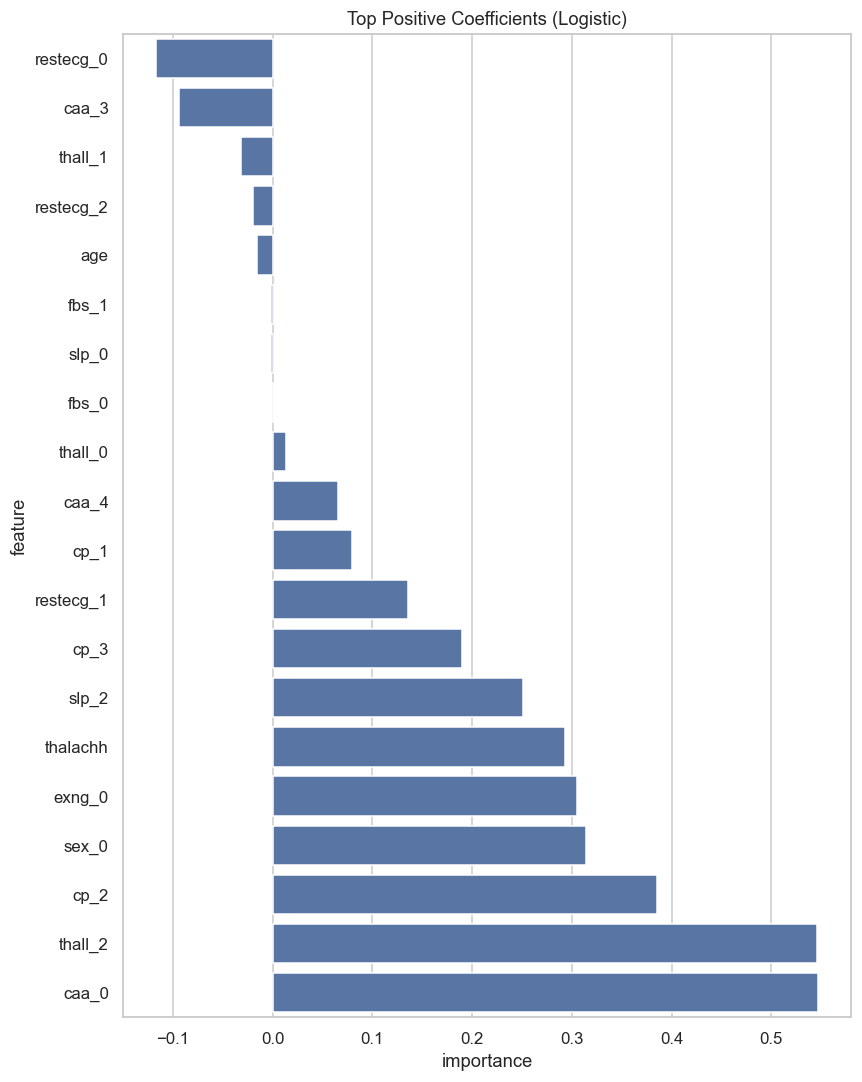

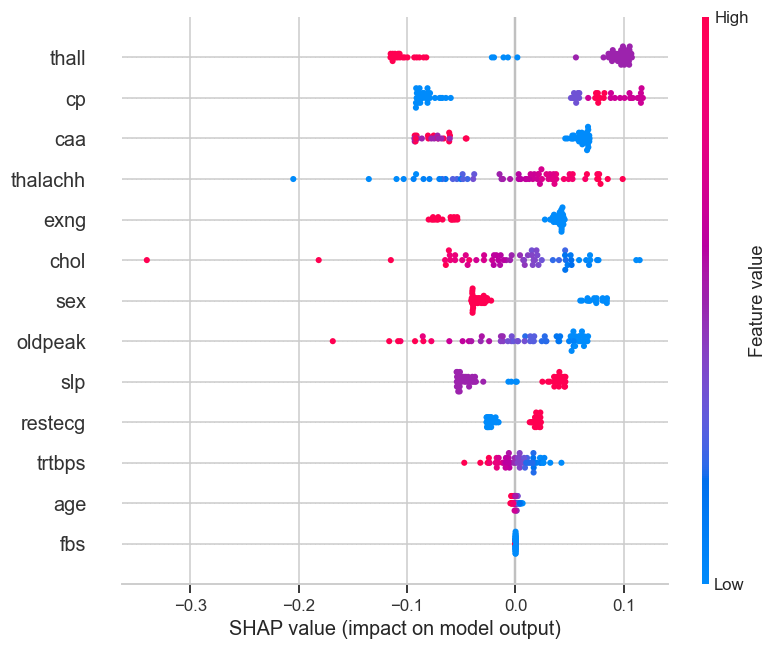

In [24]:
# Helper to extract feature names after preprocessing
from itertools import chain

def get_feature_names(preprocessor, cat_cols, num_cols):
    num_names = num_cols
    ohe = preprocessor.named_transformers_['cat']
    cat_names = list(ohe.get_feature_names_out(cat_cols))
    return list(chain(num_names, cat_names))

# Plot for logistic coefficients or tree importances
final_pipe = best_estimator
pre = final_pipe.named_steps["columntransformer"] if "columntransformer" in final_pipe.named_steps else preprocessor
feature_names = get_feature_names(pre, cat_features, num_features)

clf = [v for k, v in final_pipe.named_steps.items() if k != 'columntransformer'][0]

if hasattr(clf, 'coef_'):
    coefs = clf.coef_.ravel()
    imp_df = pd.DataFrame({'feature': feature_names, 'importance': coefs})
    imp_df = imp_df.sort_values('importance')
    plt.figure(figsize=(8,10))
    sns.barplot(data=imp_df.tail(20), x='importance', y='feature')
    plt.title('Top Positive Coefficients (Logistic)')
    plt.tight_layout(); plt.show()
elif hasattr(clf, 'feature_importances_'):
    imps = clf.feature_importances_
    imp_df = pd.DataFrame({'feature': feature_names, 'importance': imps}).sort_values('importance', ascending=False)
    plt.figure(figsize=(8,10))
    sns.barplot(data=imp_df.head(20), x='importance', y='feature')
    plt.title('Top Feature Importances (Tree)')
    plt.tight_layout(); plt.show()

# Optional SHAP
try:
    import shap
    explainer = shap.Explainer(lambda X: final_pipe.predict_proba(X)[:,1], X_train, feature_names=feature_names)
    shap_values = explainer(X_test)
    shap.plots.beeswarm(shap_values, max_display=15)
except Exception as e:
    print("SHAP skipped:", e)

## 16) Persist Artifacts (model, preprocessing, metrics, plots)

In [27]:
import joblib
import json
from pathlib import Path
from sklearn.metrics import roc_curve

# Resolve optimal threshold robustly
opt_thr_val = None
try:
    opt_thr_val = float(opt_thr)  # if previously computed in this session
except Exception:
    pass

if opt_thr_val is None:
    try:
        opt_thr_val = float(opt_threshold)  # variable name used in earlier cell
    except Exception:
        opt_thr_val = None

# Try reading from artifacts summary
sum_path = ARTIFACTS_DIR / 'artifacts_summary.json'
if opt_thr_val is None and sum_path.exists():
    try:
        with open(sum_path, 'r', encoding='utf-8') as f:
            _sum = json.load(f)
        if 'opt_threshold' in _sum:
            opt_thr_val = float(_sum['opt_threshold'])
    except Exception:
        pass

# If still None, compute from ROC if we have y_test/y_proba_best; else default to 0.5
if opt_thr_val is None:
    try:
        fpr_, tpr_, thr_ = roc_curve(y_test, y_proba_best)
        youden_j = tpr_ - fpr_
        ix = int(np.argmax(youden_j))
        opt_thr_val = float(thr_[ix])
    except Exception:
        opt_thr_val = 0.5

# Optionally include cost-based threshold if previously computed
cost_sel_path = ARTIFACTS_DIR / 'threshold_cost_selection.json'
cost_based_threshold = None
if cost_sel_path.exists():
    try:
        with open(cost_sel_path, 'r', encoding='utf-8') as f:
            _cost = json.load(f)
        cost_based_threshold = float(_cost.get('best_threshold'))
    except Exception:
        cost_based_threshold = None

# Persist model pipeline
joblib.dump(best_estimator, ARTIFACTS_DIR / 'model_pipeline.joblib')

# Merge/update artifacts summary instead of overwriting blindly
try:
    summary = {}
    if sum_path.exists():
        with open(sum_path, 'r', encoding='utf-8') as f:
            summary = json.load(f)
    summary.update({
        'best_model_name': best_model_name,
        'feature_names': feature_names,
        'num_features': num_features,
        'cat_features': cat_features,
        'metrics_test': metrics_test,
        'opt_threshold': float(opt_thr_val),
    })
    if cost_based_threshold is not None:
        summary['cost_based_threshold'] = float(cost_based_threshold)
    with open(sum_path, 'w', encoding='utf-8') as f:
        json.dump(summary, f, indent=2)
except Exception as e:
    print('Warning: could not update artifacts_summary.json:', e)

print('Artifacts saved to:', ARTIFACTS_DIR.resolve())

Artifacts saved to: C:\DSAI 4204 personal project Heart Attack Analysis & Prediction Dataset\artifacts


## 17) Append Progress Notes to project process log.md

In [28]:
# Append concise progress notes to the project's process log
from datetime import datetime
import json
from pathlib import Path

LOG_PATH = Path("../project process log.md")

# Resolve thresholds robustly for logging
opt_thr_val = None
try:
    opt_thr_val = float(opt_thr)
except Exception:
    pass

if opt_thr_val is None:
    sum_path = ARTIFACTS_DIR / 'artifacts_summary.json'
    if sum_path.exists():
        try:
            with open(sum_path, 'r', encoding='utf-8') as f:
                _sum = json.load(f)
            if 'opt_threshold' in _sum:
                opt_thr_val = float(_sum['opt_threshold'])
        except Exception:
            pass

if opt_thr_val is None:
    opt_thr_val = 0.5  # final fallback

# Also include cost-based threshold if available
cost_based_thr = None
cost_sel_path = ARTIFACTS_DIR / 'threshold_cost_selection.json'
if cost_sel_path.exists():
    try:
        with open(cost_sel_path, 'r', encoding='utf-8') as f:
            _cost = json.load(f)
        cost_based_thr = float(_cost.get('best_threshold'))
    except Exception:
        cost_based_thr = None

def append_log(lines):
    ts = datetime.now().strftime('%Y-%m-%d %H:%M')
    header = f"\n\n### {ts} — Notebook progress\n"
    content = header + "\n".join(lines) + "\n"
    with open(LOG_PATH, 'a', encoding='utf-8') as f:
        f.write(content)

summary_lines = [
    f"Data loaded: {df.shape[0]} rows, {df.shape[1]} columns.",
    f"Target rate p1: {p1:.3f}.",
    f"Split: train {X_train.shape[0]}, test {X_test.shape[0]} (stratified).",
    f"Best model: {best_model_name} with CV AUC={best_score:.3f}.",
    f"Test metrics: AUC={metrics_test['roc_auc']:.3f}, F1={metrics_test['f1']:.3f}, Acc={metrics_test['acc']:.3f}.",
    f"Optimal threshold (Youden's J): {opt_thr_val:.3f}.",
]
if cost_based_thr is not None:
    summary_lines.append(f"Cost-based threshold: {cost_based_thr:.3f} (C_FN={C_FN}, C_FP={C_FP}).")
summary_lines.append("Artifacts saved to ./artifacts (model, metrics, split, summary).")

append_log(summary_lines)
print("Progress appended to process log.")

Progress appended to process log.
